<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 데이터 및 모듈 불러오기 (추후 합치기)

In [1]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 354 kB/s 


In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('lending_club_data_preprocessed.csv').iloc[:,1:]
print(df.shape)
df.head()

(523215, 85)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_payment
0,120122535,12000.0,12000.0,12000.0,36 months,7.97,375.88,A,A5,10+ years,OWN,42000.0,Source Verified,Sep-2017,Fully Paid,debt_consolidation,Debt consolidation,27.74,0.0,715.0,719.0,0.0,9.0,1.0,11457.0,37.0,16.0,w,694.0,690.0,Individual,0.0,0.0,30502.0,1.0,2.0,1.0,3.0,8.0,19045.0,...,31000.0,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,8.0,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,Paid
1,119374887,32000.0,32000.0,32000.0,36 months,11.99,1062.71,B,B5,10+ years,MORTGAGE,155000.0,Source Verified,Sep-2017,Current,credit_card,Credit card refinancing,12.35,2.0,715.0,719.0,1.0,20.0,0.0,48309.0,34.1,42.0,w,674.0,670.0,Individual,0.0,0.0,405751.0,2.0,1.0,1.0,1.0,8.0,15582.0,...,142600.0,0.0,2.0,2.0,8.0,22542.0,81313.0,34.5,0.0,0.0,91.0,144.0,1.0,1.0,3.0,1.0,1.0,0.0,7.0,10.0,12.0,27.0,3.0,18.0,36.0,10.0,20.0,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,Paid
2,119321612,40000.0,40000.0,40000.0,60 months,15.05,952.65,C,C4,more than 4 years and less than 9 years,MORTGAGE,120000.0,Verified,Sep-2017,Current,debt_consolidation,Debt consolidation,31.11,0.0,765.0,769.0,0.0,12.0,0.0,13389.0,20.7,26.0,w,769.0,765.0,Individual,0.0,0.0,227506.0,2.0,3.0,2.0,4.0,3.0,140872.0,...,64600.0,2.0,3.0,1.0,4.0,20682.0,51211.0,20.7,0.0,0.0,122.0,185.0,26.0,3.0,4.0,26.0,11.0,0.0,4.0,4.0,6.0,8.0,9.0,7.0,13.0,4.0,12.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,367745.0,154261.0,64600.0,168145.0,Paid
3,120122034,16000.0,16000.0,16000.0,36 months,7.97,501.17,A,A5,more than 4 years and less than 9 years,RENT,79077.0,Not Verified,Sep-2017,Current,debt_consolidation,Debt consolidation,15.94,0.0,700.0,704.0,0.0,12.0,0.0,16217.0,57.7,20.0,w,674.0,670.0,Individual,0.0,0.0,128572.0,0.0,1.0,0.0,0.0,38.0,112355.0,...,28100.0,0.0,0.0,0.0,0.0,10714.0,336.0,90.9,0.0,0.0,145.0,207.0,32.0,32.0,0.0,206.0,NaN,2.0,2.0,11.0,2.0,2.0,9.0,11.0,11.0,11.0,12.0,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,128572.0,3700.0,96918.0,Paid
4,118659541,33000.0,33000.0,33000.0,36 months,7.21,1022.12,A,A3,less than 3 years,MORTGAGE,107000.0,Verified,Sep-2017,Late (31-120 days),debt_consolidation,Debt consolidation,19.06,0.0,785.0,789.0,0.0,25.0,0.0,18533.0,16.1,52.0,w,709.0,705.0,Joint App,0.0,0.0,244459.0,2.0,2.0,0.0,0.0,46.0,29686.0,...,115000.0,0.0,1.0,0.0,6.0,9778.0,65368.0,20.0,0.0,0.0,141.0,133.0,5.0,5.0,2.0,6.0,19.0,0.0,4.0,10.0,10.0,19.0,12.0,22.0,38.0,10.0,25.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,404510.0,48219.0,81700.0,73015.0,Default


# 3. 모델링

In [13]:
# 평가지표 함수
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label: Default")
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1-Score: ", F1_Score)

## 3.1 타겟 지정 및 데이터 세트 분할

In [6]:
# test set 만들기
test = df[(df['issue_d'] == 'Sep-2020') | (df['issue_d'] == 'May-2020')]
train = df.drop(test.index)

# validation set 만들기
train, val = train_test_split(train, train_size = 0.8, random_state=2)

In [7]:
# target 지정 및 데이터 세트 분할
# loan_payment: Target, id: Always unique, issue_d: Date, grade: Duplicative of sub_grade
target= 'loan_payment'
features = train.drop(columns=['loan_payment','id','issue_d','grade']).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [8]:
print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (406625, 81)
X_val shape (101657, 81)
X_test shape (14933, 81)


In [9]:
# Data Processing Pipeline
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# Scailing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_val_scaled = scaler.transform(X_val_processed)

## 3.2 Majority class baseline

In [10]:
y_train.value_counts(normalize=True)

Paid       0.901137
Default    0.098863
Name: loan_payment, dtype: float64

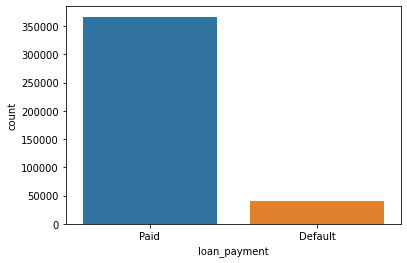

In [ ]:
sns.countplot(x=y_train)

In [14]:
# 기준모델 학습세트
major = y_train.mode()[0]
y_pred = [major] *len(y_train)
print("기준모델 학습세트 평가")
model_evaluation(y_train, y_pred)

# 기준모델 검증세트
y_val = val[target]
y_pred = [major] * len(y_val)
print("기준모델 검증세트 평가")
model_evaluation(y_val, y_pred)

기준모델 학습세트 평가
Model_Evaluation with Label:1
Accuracy:  0.901137411620043
Precision:  0.901137411620043
Recall:  1.0
F1-Score:  0.9479981889916564
기준모델 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.902623528138741
Precision:  0.902623528138741
Recall:  1.0
F1-Score:  0.9488198950443347


## 3.3 Logistic Regression

In [16]:
lr = LogisticRegression(random_state=1, n_jobs=-1)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr)

로지스틱 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.9999803259982096
Precision:  1.0
Recall:  0.9999782035353866
F1-Score:  0.9999891016489205


In [40]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train_scaled, y_train)
y_pred_dtc = dtc.predict(X_val_scaled)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc)

결정트리 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


# 4. SMOTE를 이용한 Oversampling 후, 모델링

In [21]:
print("OverSampling 전, 'Default' 라벨의 수: {}".format(sum(y_train == 'Default')))
print("OverSampling 전, 'Paid' 라벨의 수: {}".format(sum(y_train == 'Paid')))

OverSampling 전, 'Default' 라벨의 수: 40200
OverSampling 전, 'Paid' 라벨의 수: 366425


In [64]:
# SMOTE 알고리즘 활용하여 Oversampling 진행
sm = SMOTE(random_state = 10) 
X_train_res, y_train_res = sm.fit_sample(X_train_processed, y_train.ravel()) 

In [65]:
print("OverSampling 후, 'Default' 라벨의 수: {}".format(sum(y_train_res == 'Default')))
print("OverSampling 후, 'Paid' 라벨의 수: {}".format(sum(y_train_res == 'Paid')))

OverSampling 후, 'Default' 라벨의 수: 366425
OverSampling 후, 'Paid' 라벨의 수: 366425


In [66]:
pd.Series(y_train_res).value_counts(normalize=True)

Paid       0.5
Default    0.5
dtype: float64

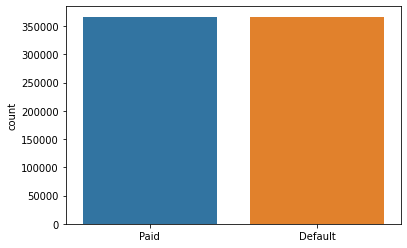

In [67]:
sns.countplot(x=pd.Series(y_train_res))

In [54]:
lr2 = LogisticRegression(random_state=10, n_jobs=-1)
lr2.fit(X_train_res, y_train_res)
y_pred_lr2 = lr2.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr2)

로지스틱 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.6034606569149198
Precision:  0.988529104548476
Recall:  0.5672638897970749
F1-Score:  0.7208630801936113


In [71]:
lr2 = LogisticRegression(random_state=10, n_jobs=-1)
lr2.fit(X_train_res, y_train_res)
y_pred_lr2 = lr2.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr2)

로지스틱 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.6946594922140138
Precision:  0.9911505856467999
Recall:  0.6676802022711916
F1-Score:  0.7978771895552517


In [69]:
dtc2 = DecisionTreeClassifier(random_state=10)
dtc2.fit(X_train_res, y_train_res)
y_pred_dtc2 = dtc2.predict(X_val_processed)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc2)

결정트리 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


In [45]:
rfc2 = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc2.fit(X_train_res, y_train_res)
y_pred_rfc2 = rfc2.predict(X_val_scaled)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_rfc2)

결정트리 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.9204875217643644
Precision:  0.9190412756282489
Recall:  1.0
F1-Score:  0.957812932217809


In [74]:
rfc2 = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, n_estimators=300)
rfc2.fit(X_train_res, y_train_res)
y_pred_rfc2 = rfc2.predict(X_val_scaled)

print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc2)

랜덤포레스트 검증세트 평가
Model_Evaluation with Label:1
Accuracy:  0.9089979047188094
Precision:  0.919699266478793
Recall:  0.9852002005274745
F1-Score:  0.9513235920884394


In [49]:
y_pred_rfc2 = rfc2.predict(X_val_scaled)
model_evaluation(y_val, y_pred_dtc2)

Model_Evaluation with Label:1
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0
